In [17]:
import pandas as pd
from skimage.feature import blob_log
from numpy import unravel_index
from math import sqrt
from geopandas import read_file
from rasterstats import zonal_stats
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects # for white buffer around labels on Africa map
%matplotlib inline

# Get Every Country in Africa

Using natural earth country data. Source: http://www.naturalearthdata.com/downloads/110m-cultural-vectors/

In [18]:
countries = read_file("input/ne_110m_admin_0_countries/ne_110m_admin_0_countries.shp")

In [19]:
africa = countries[countries['CONTINENT'] == 'Africa']
africa.reset_index(inplace=True, drop=True)

In [20]:
africa.crs

{'init': u'epsg:4326'}

In [21]:
africa['coords'] = africa['geometry'].apply(lambda x: x.centroid.coords[:])
africa['coords'] = [coords[0] for coords in africa['coords']]

/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


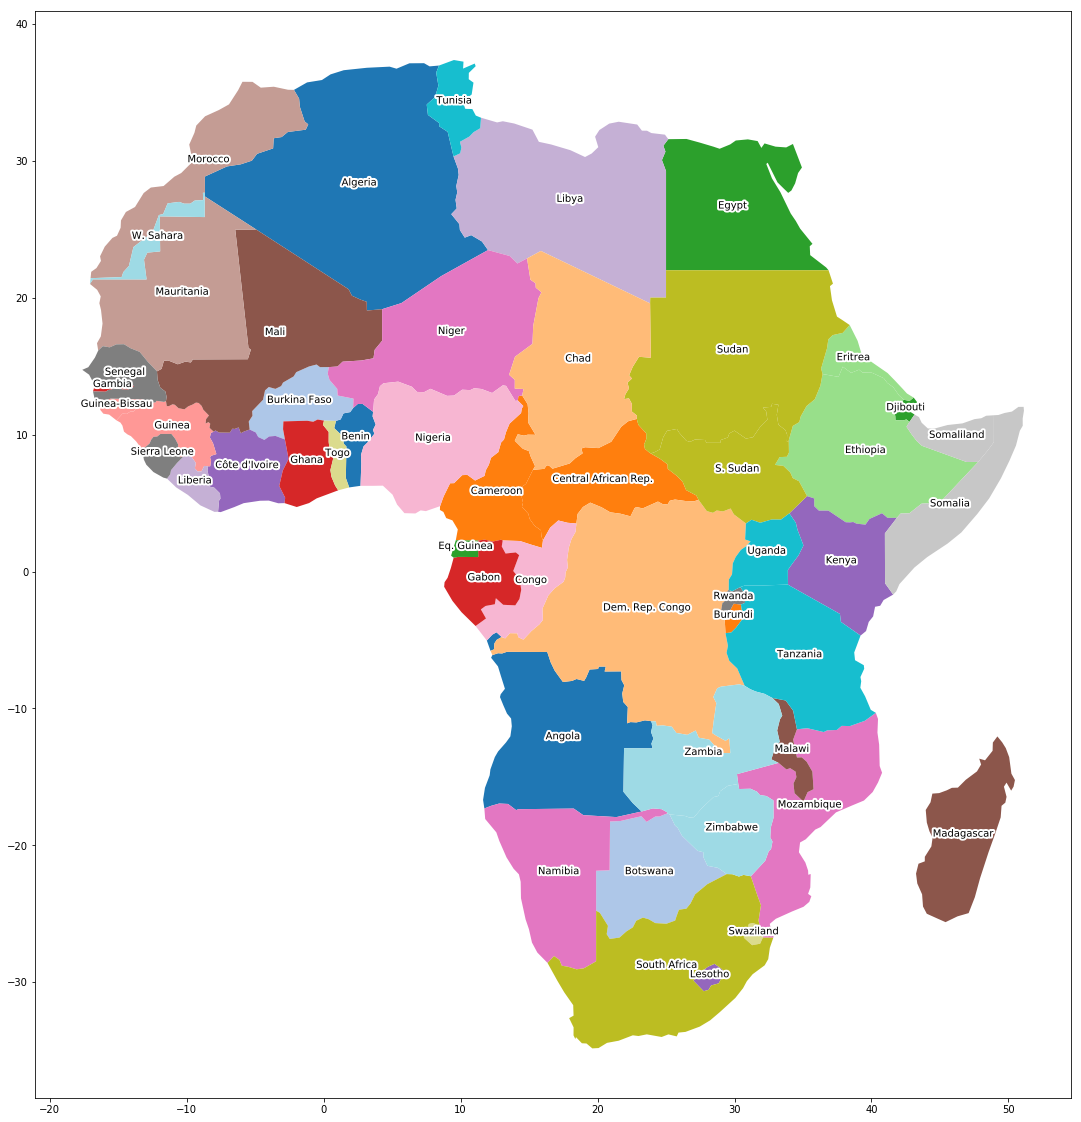

In [22]:
africa.plot(figsize=(30,20), column='ADMIN', cmap='Vega20')
for idx, row in africa.iterrows():
    plt.annotate(s=row['NAME'], xy=row['coords'],
                 horizontalalignment='center',
                path_effects=[PathEffects.withStroke(linewidth=4, foreground="white")])
plt.show()

Add a buffer around each country. **Note: Need to figure out how big this buffer is in miles**

In [23]:
africa.geometry = africa.geometry.buffer(2)

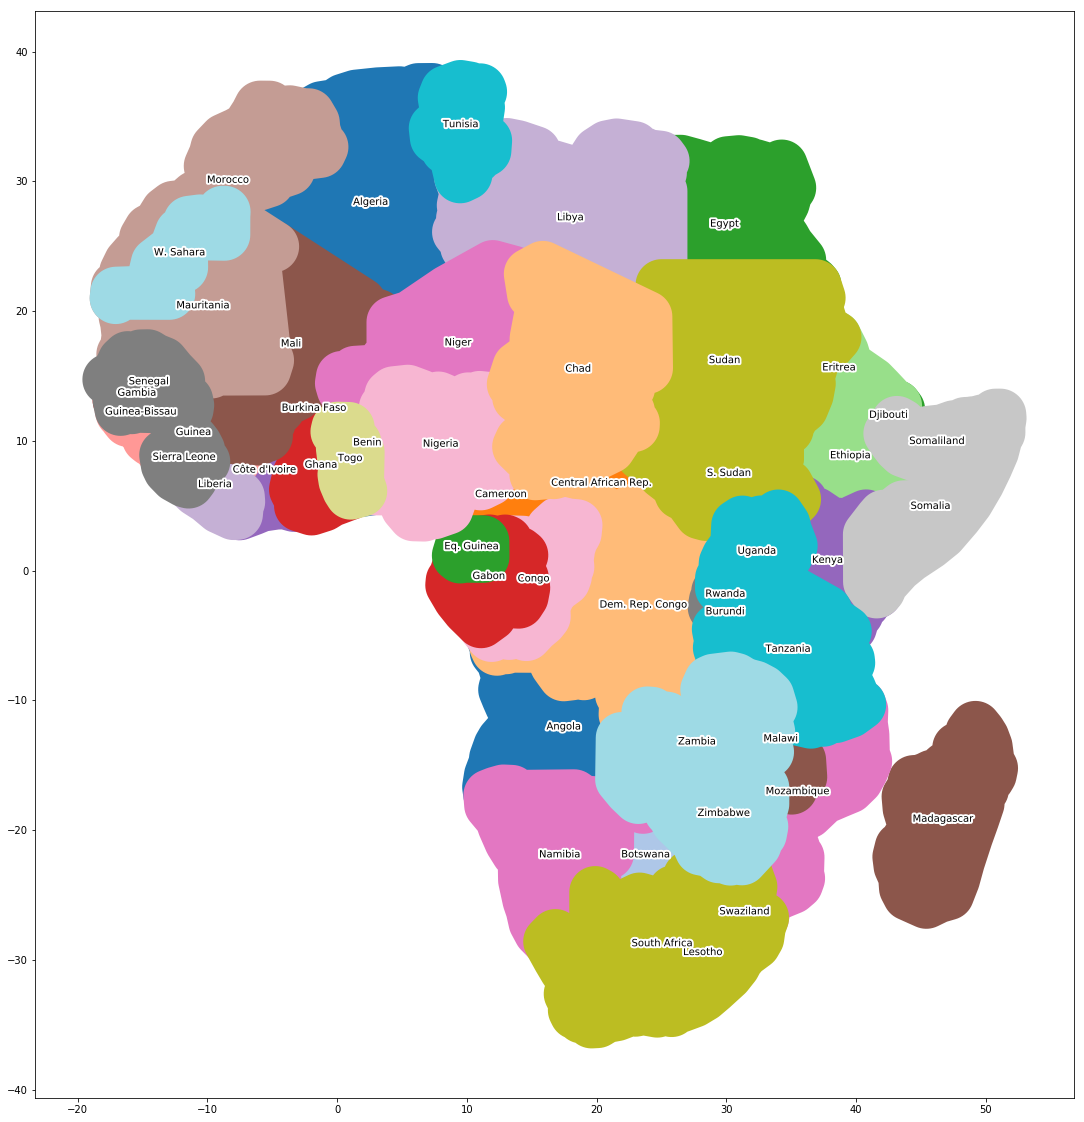

In [24]:
africa.plot(figsize=(30,20), column='ADMIN', cmap='Vega20')
for idx, row in africa.iterrows():
    plt.annotate(s=row['NAME'], xy=row['coords'],
                 horizontalalignment='center',
                path_effects=[PathEffects.withStroke(linewidth=4, foreground="white")])
plt.show()

# Detect blobs and get raster stats (max cell)

In [25]:
GPW_minus_BM_path = 'output/GPW_minus_BM_gte_0.tif'
BM_minus_GPW_path = 'output/BM_minus_GPW_gte_0.tif'

In [10]:
%%time

# store results in a list
results = []
errors = []

count = 0

# for every country in africa
for i in africa.index:
    
    # get country name
    country_name = africa.loc[i]['ADMIN']
    
    try:
        
        # print country name
        print country_name, "(", count, "/", len(africa), ")"
        count += 1

        # get country polygon
        polygon = africa.loc[[i]]

        # get zonal stats clipped to country border for GPW minus BM
        GPW_minus_BM_stats_clipped = zonal_stats(
                            polygon,
                            GPW_minus_BM_path,
                            all_touched=True,
                            add_stats={'maxcell': lambda x: unravel_index(x.argmax(), x.shape)},
                            raster_out=True
                        )[0]
        # get zonal stats clipped to country border for BM minus GPW
        BM_minus_GPW_stats_clipped = zonal_stats(
                            polygon,
                            BM_minus_GPW_path,
                            all_touched=True,
                            add_stats={'maxcell': lambda x: unravel_index(x.argmax(), x.shape)},
                            raster_out=True
                        )[0]
        
        # get zonal stats clipped to country *extent* for GPW minus BM
        # (we need it this way for blob detection)
        GPW_minus_BM_stats_extent = zonal_stats(
                            polygon.envelope,
                            GPW_minus_BM_path,
                            all_touched=True,
                            add_stats={'maxcell': lambda x: unravel_index(x.argmax(), x.shape)},
                            raster_out=True
                        )[0]

        # get zonal stats clipped to country *extent* for BM minus GPW
        # (we need it this way for blob detection)
        BM_minus_GPW_stats_extent = zonal_stats(
                            polygon.envelope,
                            BM_minus_GPW_path,
                            all_touched=True,
                            add_stats={'maxcell': lambda x: unravel_index(x.argmax(), x.shape)},
                            raster_out=True
                        )[0]

        # function to convert row, col pixel coordinates to lat, lon
        def pixel2coord(transform, row, col):
            ''' converts row col to lat, lon'''
            coff, roff = (0.5, 0.5)
            x, y = transform * transform.translation(coff, roff) * (col, row)
            return y, x

        # function to detect blobs in image
        def detect_blobs(array, threshold):
            array.mask = False
            blobs = blob_log(array, max_sigma=30, num_sigma=10, threshold=threshold)
            # Compute blob radius in the 3rd column.
            blobs[:, 2] = blobs[:, 2] * sqrt(2)
            # Convert pixels to lat, lons
            blob_coords = [pixel2coord(GPW_minus_BM_stats_extent['mini_raster_affine'], i[0], i[1]) for i in blobs]
            return blob_coords
        
        
        # get max cell with most people least lights
        maxcell_people_no_lights = pixel2coord(GPW_minus_BM_stats_clipped['mini_raster_affine'], 
                                               *GPW_minus_BM_stats_clipped['maxcell'])        
        print "cell with most people least lights:", maxcell_people_no_lights
        
        # build dataframe containing max cell with most people least lights
        maxcell_people_no_lights_lats = maxcell_people_no_lights[0]
        maxcell_people_no_lights_lons = maxcell_people_no_lights[1]
        maxcell_people_no_lights_df = pd.DataFrame()
        maxcell_people_no_lights_df['latitude'] = [maxcell_people_no_lights_lats]
        maxcell_people_no_lights_df['longitude'] = [maxcell_people_no_lights_lons]
        maxcell_people_no_lights_df['country_name_searched'] = [country_name]
        maxcell_people_no_lights_df['category'] = ["people_no_lights"]
        maxcell_people_no_lights_df['is_max'] = [1]
        
        # get max cell with most lights least people
        maxcell_lights_no_people = pixel2coord(BM_minus_GPW_stats_clipped['mini_raster_affine'], 
                                               *BM_minus_GPW_stats_clipped['maxcell'])
        print "cell with most lights least people:", maxcell_lights_no_people
        
        # build dataframe containing max cell with most people least lights
        maxcell_lights_no_people_lats = maxcell_lights_no_people[0]
        maxcell_lights_no_people_lons = maxcell_lights_no_people[1]
        maxcell_lights_no_people_df = pd.DataFrame()
        maxcell_lights_no_people_df['latitude'] = [maxcell_lights_no_people_lats]
        maxcell_lights_no_people_df['longitude'] = [maxcell_lights_no_people_lons]
        maxcell_lights_no_people_df['country_name_searched'] = [country_name]
        maxcell_lights_no_people_df['category'] = ["lights_no_people"]
        maxcell_lights_no_people_df['is_max'] = [1]
        
        # blob detection for people no lights
        people_no_lights = detect_blobs(GPW_minus_BM_stats_extent['mini_raster_array'], 
                                    threshold=0.3)
        print len(people_no_lights), "people-no-lights blobs found"

        # build dataframe containing people no lights blobs
        people_no_lights_lats = [i[0] for i in people_no_lights]
        people_no_lights_lons = [i[1] for i in people_no_lights]
        people_no_lights_df = pd.DataFrame()
        people_no_lights_df['latitude'] = people_no_lights_lats
        people_no_lights_df['longitude'] = people_no_lights_lons
        people_no_lights_df['country_name_searched'] = country_name
        people_no_lights_df['category'] = "people_no_lights"
        people_no_lights_df['is_max'] = 0

        # blob detection for lights no people
        lights_no_people = detect_blobs(BM_minus_GPW_stats_extent['mini_raster_array'],
                                   threshold=0.1)
        print len(lights_no_people), "lights-no-people blobs found"

        # build dataframe containing lights no people blobs
        lights_no_people_lats = [i[0] for i in lights_no_people]
        lights_no_people_lons = [i[1] for i in lights_no_people]
        lights_no_people_df = pd.DataFrame()
        lights_no_people_df['latitude'] = lights_no_people_lats
        lights_no_people_df['longitude'] = lights_no_people_lons
        lights_no_people_df['country_name_searched'] = country_name
        lights_no_people_df['category'] = "lights_no_people"
        lights_no_people_df['is_max'] = 0

        # concatenate the four dataframes into one dataframe
        this_df = pd.concat([people_no_lights_df, lights_no_people_df, maxcell_people_no_lights_df, maxcell_lights_no_people_df])

        # append the concatenated dataframe to the results list
        results.append(this_df)
        
    except StandardError as e:
        
        # if error append country name to errors list
        print "Error:",e, country_name
        errors.append(country_name)

Angola ( 0 / 51 )


/anaconda/lib/python2.7/site-packages/rasterstats/main.py:142: FutureWarning: The value of this property will change in version 1.0. Please see https://github.com/mapbox/rasterio/issues/86 for details.
  with Raster(raster, affine, nodata, band) as rast:
/anaconda/lib/python2.7/site-packages/rasterstats/io.py:242: FutureWarning: GDAL-style transforms are deprecated and will not be supported in Rasterio 1.0.
  self.affine = guard_transform(self.src.transform)
/anaconda/lib/python2.7/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


cell with most people least lights: (-4.5041666666580866, 15.537500000001334)
cell with most lights least people: (-5.1958333333247584, 11.687500000001306)
34 people-no-lights blobs found
65 lights-no-people blobs found
Burundi ( 1 / 51 )
cell with most people least lights: (-0.43749999999139078, 30.437500000001428)
cell with most lights least people: (-5.9208333333247616, 29.187500000001421)
35 people-no-lights blobs found
0 lights-no-people blobs found
Benin ( 2 / 51 )
cell with most people least lights: (13.09583333334203, 4.9958333333346108)
cell with most lights least people: (5.3625000000086445, 4.3375000000012731)
45 people-no-lights blobs found
16 lights-no-people blobs found
Burkina Faso ( 3 / 51 )
cell with most people least lights: (14.462500000008715, -4.9124999999988113)
cell with most lights least people: (9.48750000000868, -5.6291666666654834)
33 people-no-lights blobs found
10 lights-no-people blobs found
Botswana ( 4 / 51 )
cell with most people least lights: (-20.0291

45 people-no-lights blobs found
1 lights-no-people blobs found
Western Sahara ( 35 / 51 )
cell with most people least lights: (27.337500000008802, -13.07083333333218)
cell with most lights least people: (27.154166666675465, -13.195833333332182)
18 people-no-lights blobs found
17 lights-no-people blobs found
Sudan ( 36 / 51 )
cell with most people least lights: (23.995833333342109, 32.545833333334784)
cell with most lights least people: (10.912500000008686, 28.562500000001428)
54 people-no-lights blobs found
84 lights-no-people blobs found
South Sudan ( 37 / 51 )
cell with most people least lights: (14.120833333342045, 33.679166666668131)
cell with most lights least people: (10.912500000008688, 28.562500000001432)
40 people-no-lights blobs found
17 lights-no-people blobs found
Senegal ( 38 / 51 )
cell with most people least lights: (16.004166666675381, -16.320833333332203)
cell with most lights least people: (13.770833333342035, -13.679166666665518)
25 people-no-lights blobs found
2 lig

In [11]:
print len(results), "successes"
print len(errors), "errors"

51 successes
0 errors


In [12]:
blobs = pd.concat(results)
blobs.reset_index(drop=True, inplace=True)
blobs.head()

,latitude,longitude,country_name_searched,category,is_max
0,-19.254167,17.704167,Angola,people_no_lights,0
1,-17.954167,25.845833,Angola,people_no_lights,0
2,-17.920833,19.770833,Angola,people_no_lights,0
3,-17.729167,25.920833,Angola,people_no_lights,0
4,-17.520833,24.287500,Angola,people_no_lights,0


In [13]:
#blobs.to_csv("output/africa/africa_v4.csv")

In [15]:
blobs.shape

(5688, 5)